In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


# **Library**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from autogluon.tabular import TabularPredictor
warnings.filterwarnings("ignore")

# **Explore Data**

In [7]:
train_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/train.csv")
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [8]:
test_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/test.csv")
test_df.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7197  
1  -1.4852   9.8714  19.1293 -20.9760  
2  -7.1086   7.0618  19.8956 -23.1794  
3   3.9567   9.2295  13.0168  -4.2108  
4  -5.1612   7.2882  13.9260  -9.1846  

[5 rows x 201 columns]

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [10]:
train_df['var_0'].value_counts()

var_0
13.0656    11
8.6649     11
10.6829    11
9.5114     10
10.9468    10
           ..
9.1800      1
7.3502      1
11.5106     1
14.5987     1
14.1869     1
Name: count, Length: 94672, dtype: int64

# **Analyze Data**

## **Distribution**

In [48]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature],label=label1)
        sns.kdeplot(df2[feature],label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.legend()
    plt.show()

### Data 0,1

<Figure size 640x480 with 0 Axes>

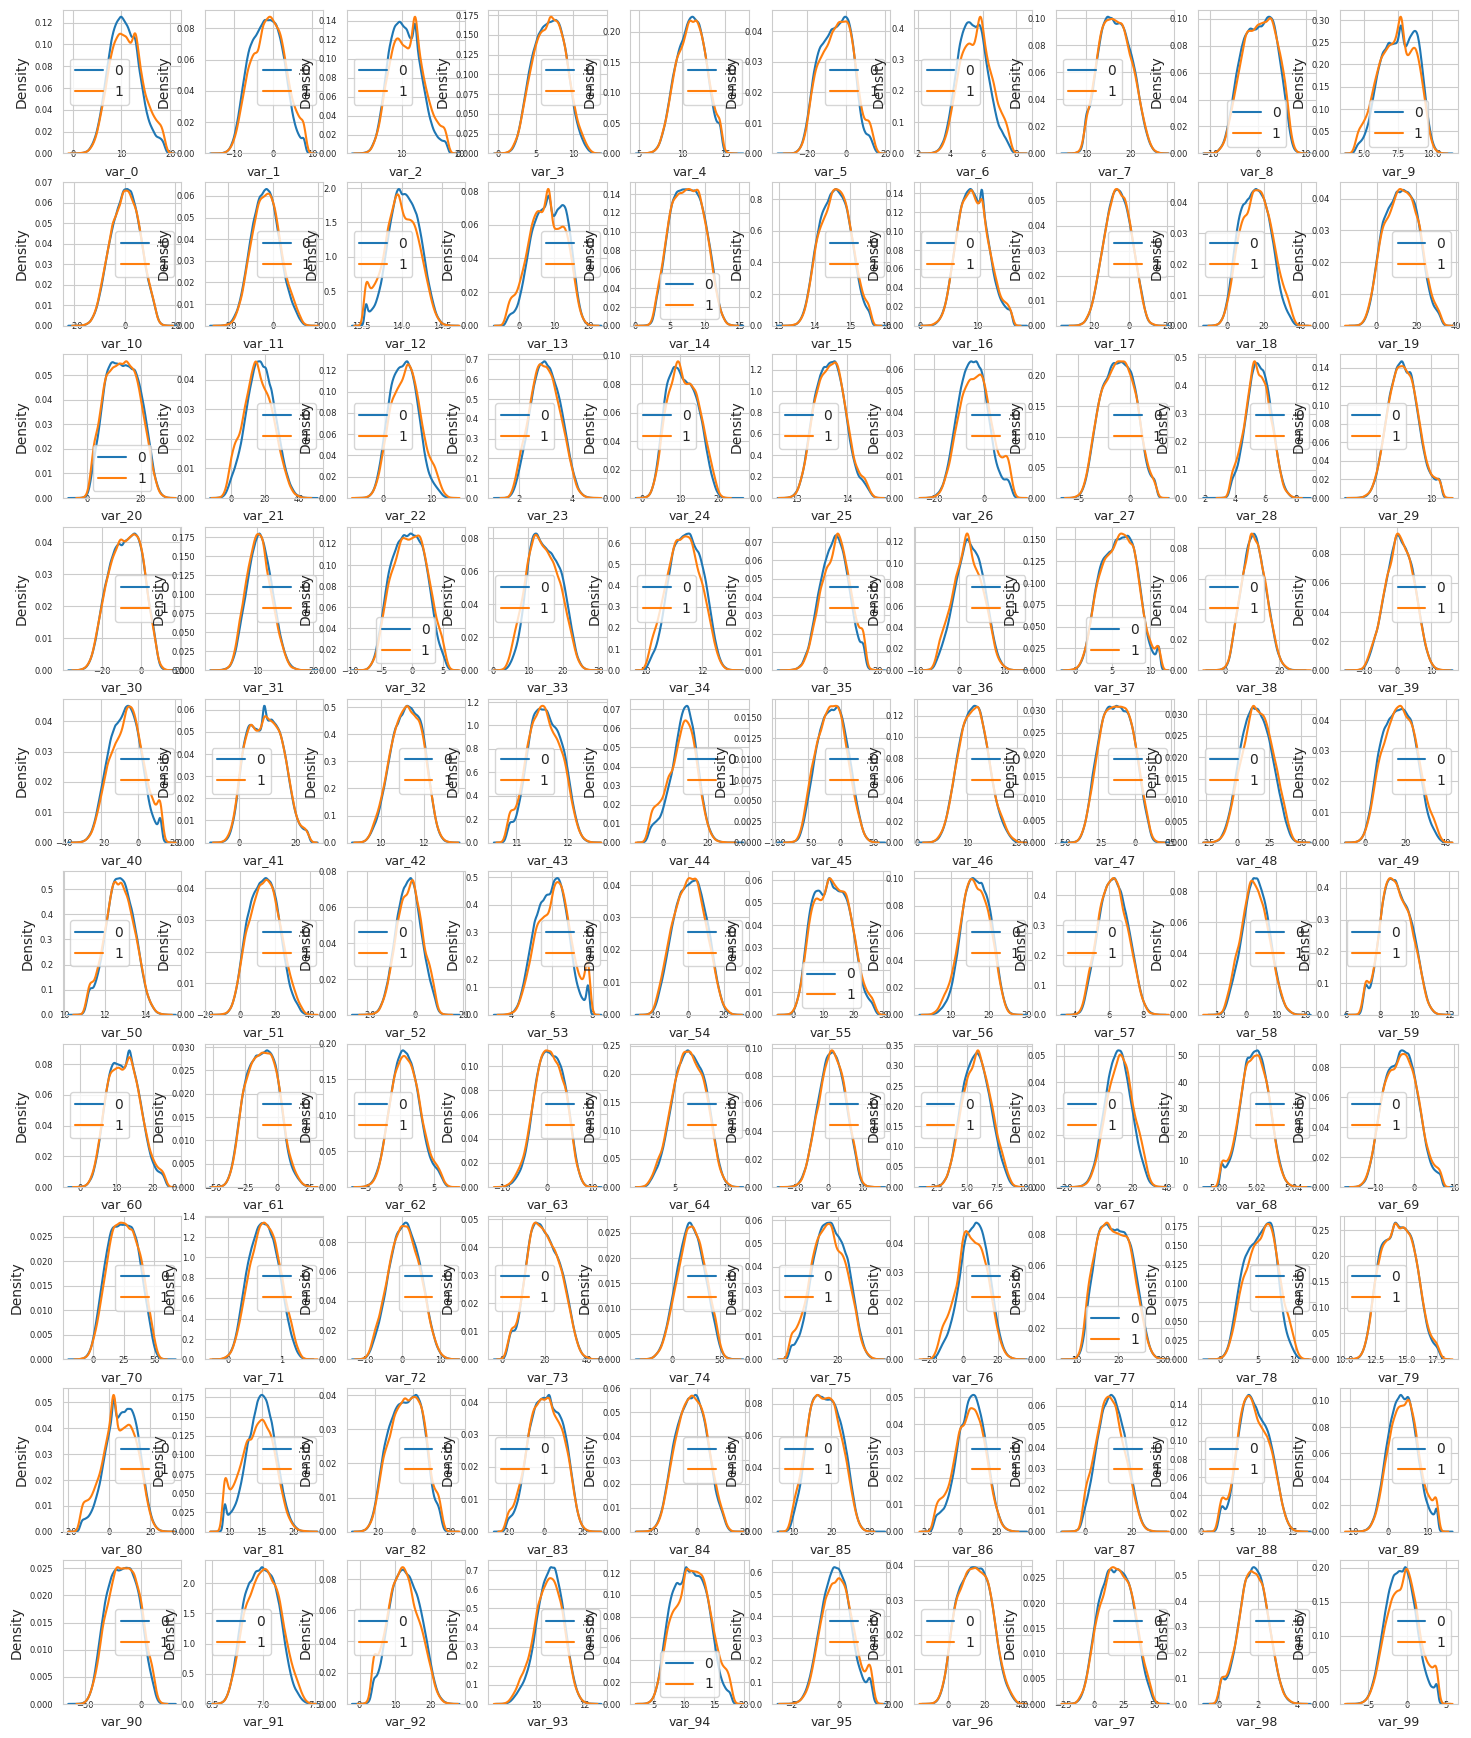

In [49]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 640x480 with 0 Axes>

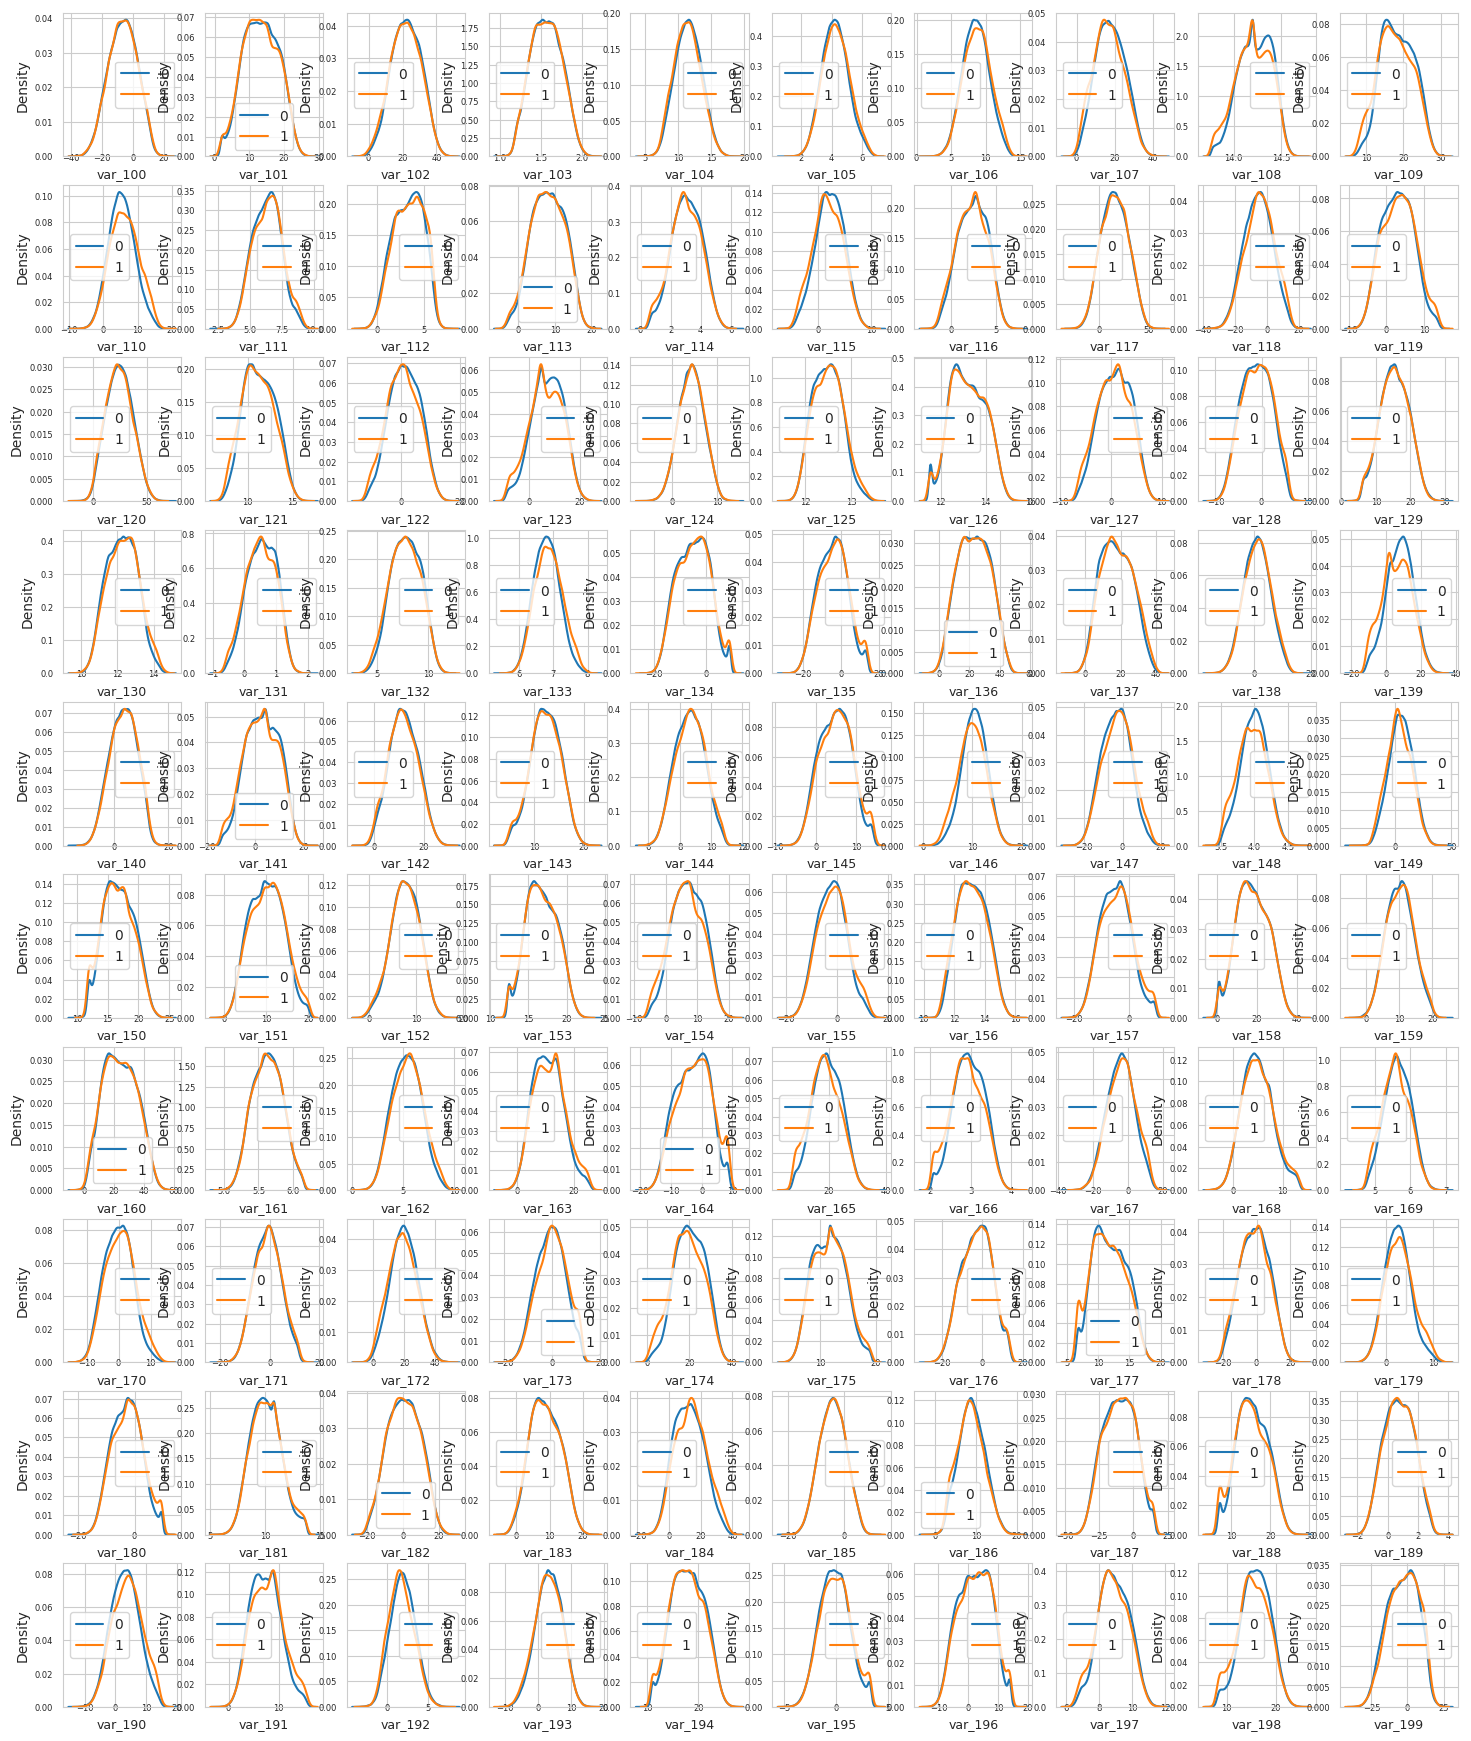

In [50]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

### Data train,test

<Figure size 640x480 with 0 Axes>

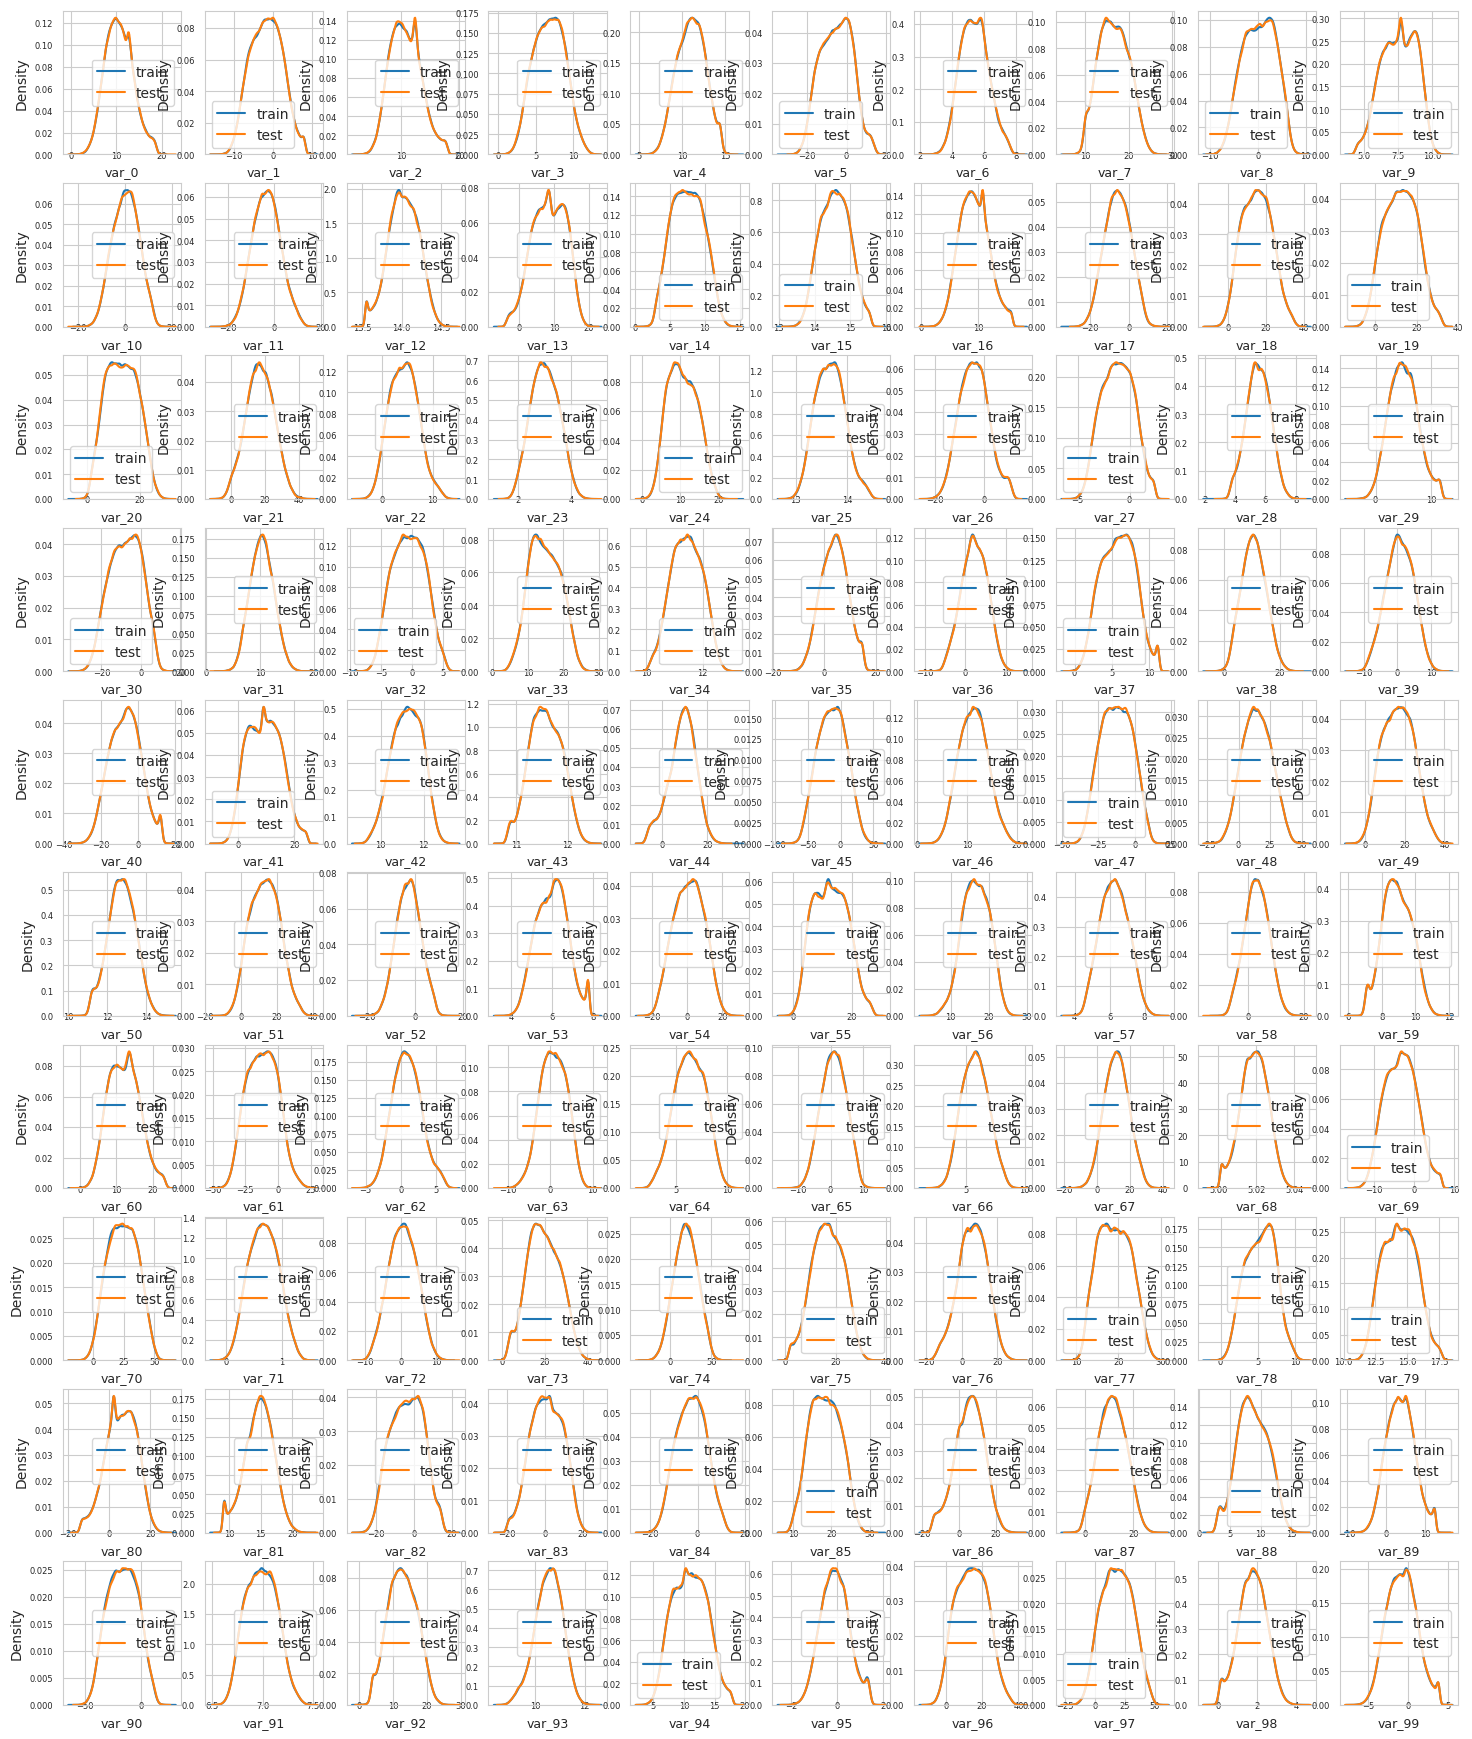

In [51]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

<Figure size 640x480 with 0 Axes>

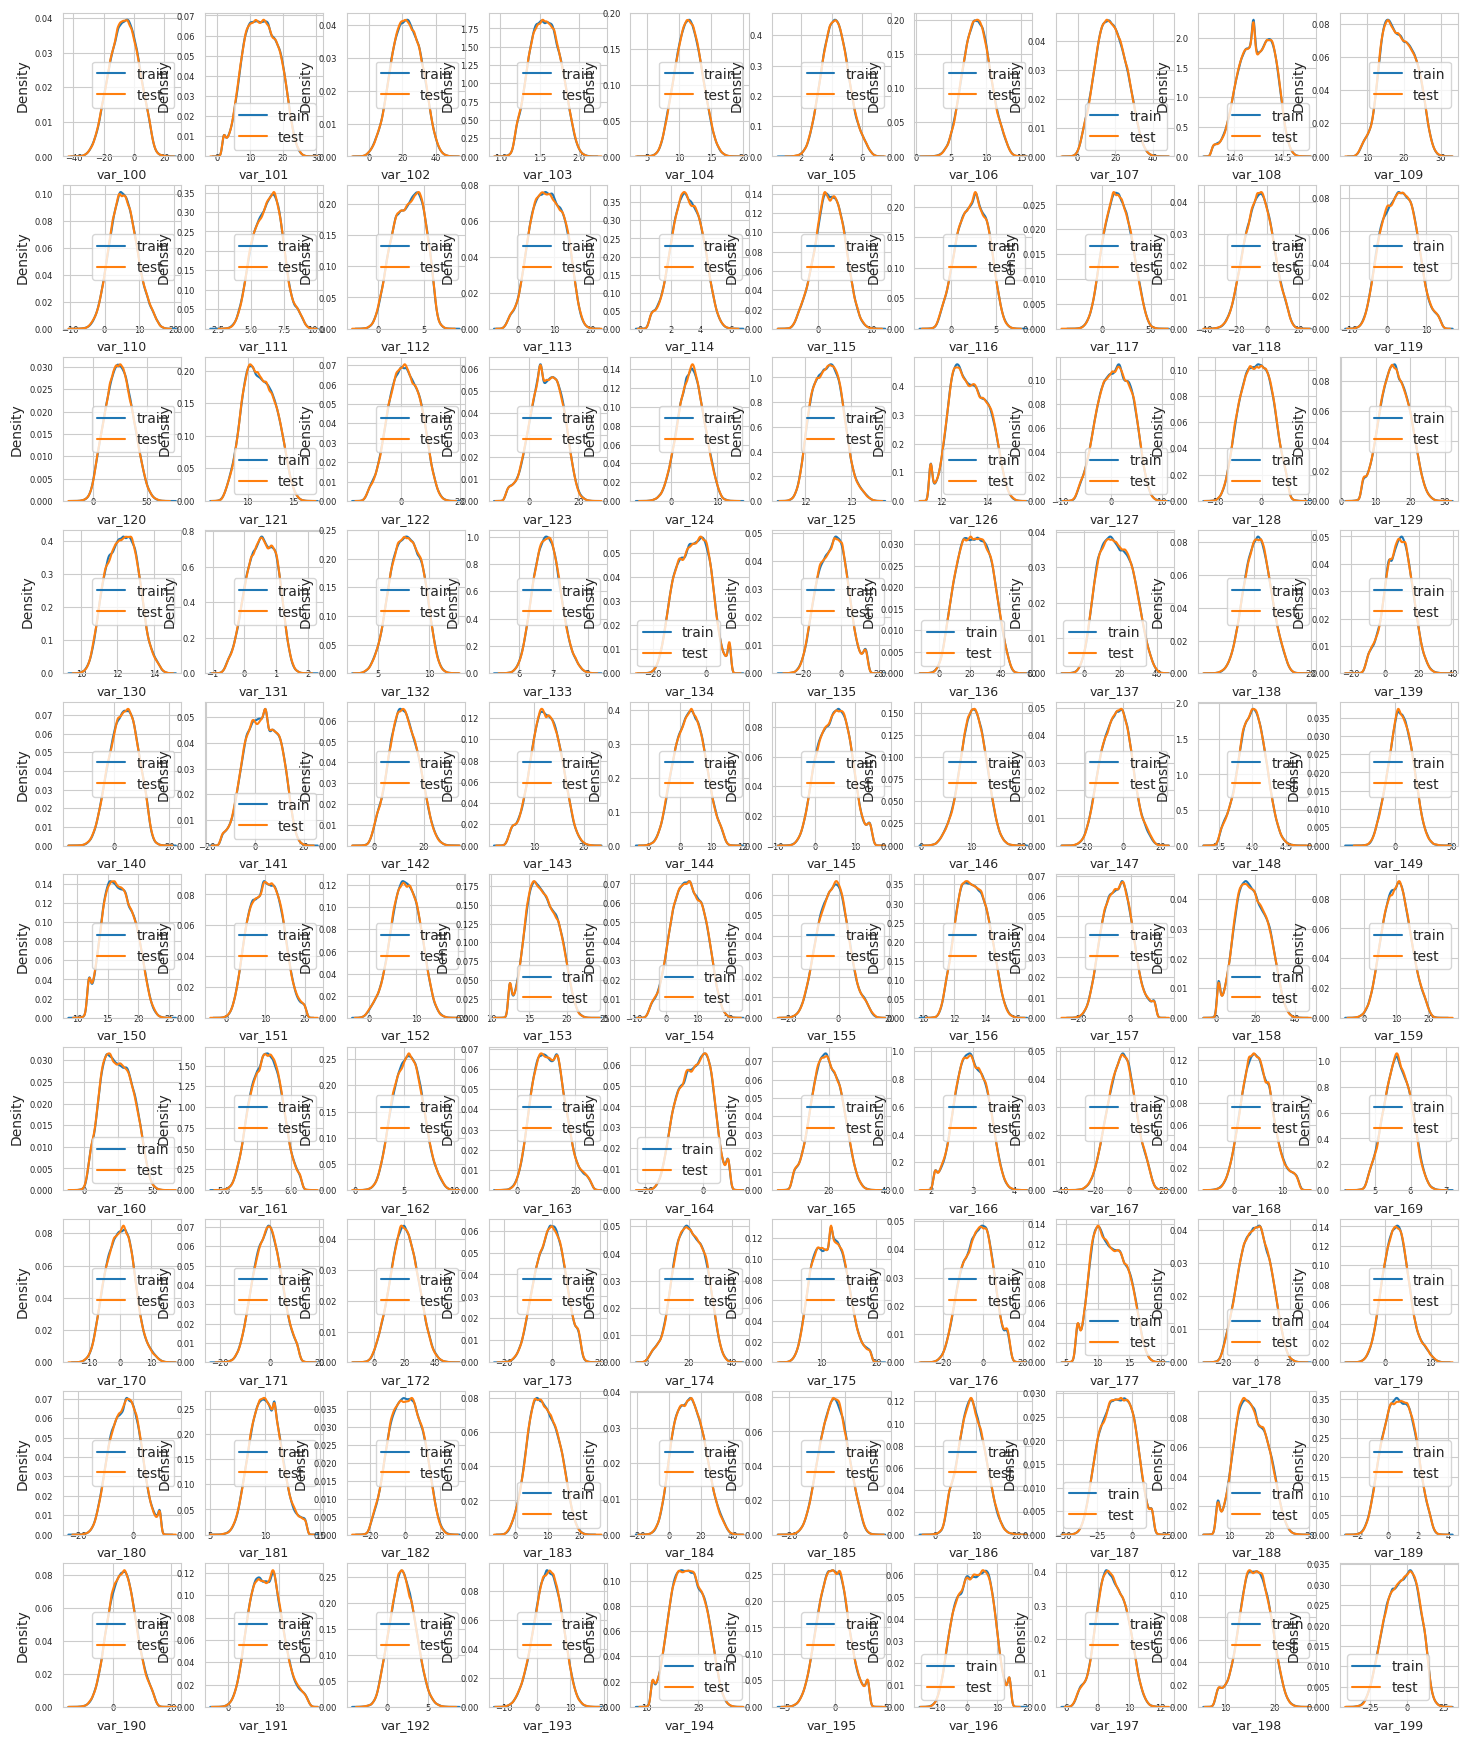

In [52]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

### Mean

<Figure size 640x480 with 0 Axes>

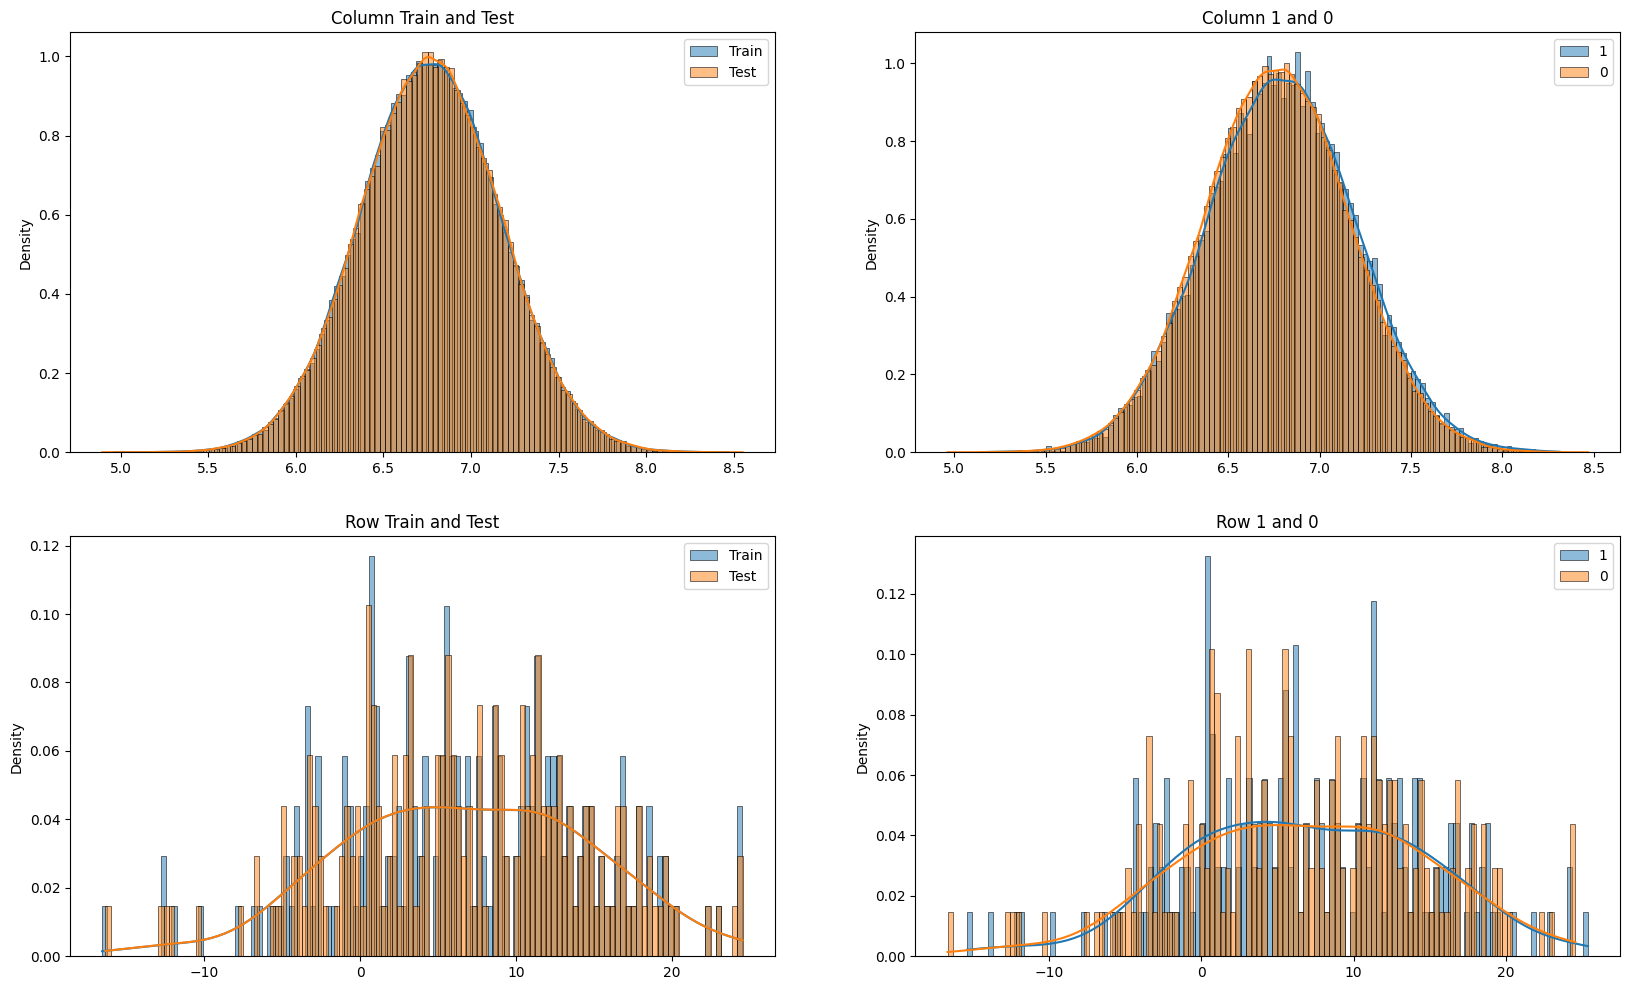

In [47]:
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[2:202]
plt.subplot(2,2,1)
plt.title('Column Train and Test')
sns.histplot(data = train_df[features].mean(axis = 1), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].mean(axis = 1), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,2)
plt.title('Column 1 and 0')
sns.histplot(data = t1[features].mean(axis = 1), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].mean(axis = 1), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,3)
plt.title('Row Train and Test')
sns.histplot(data = train_df[features].mean(axis = 0), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].mean(axis = 0), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,4)
plt.title('Row 1 and 0')
sns.histplot(data = t1[features].mean(axis = 0), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].mean(axis = 0), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.show()

### Standard deviation

<Figure size 640x480 with 0 Axes>

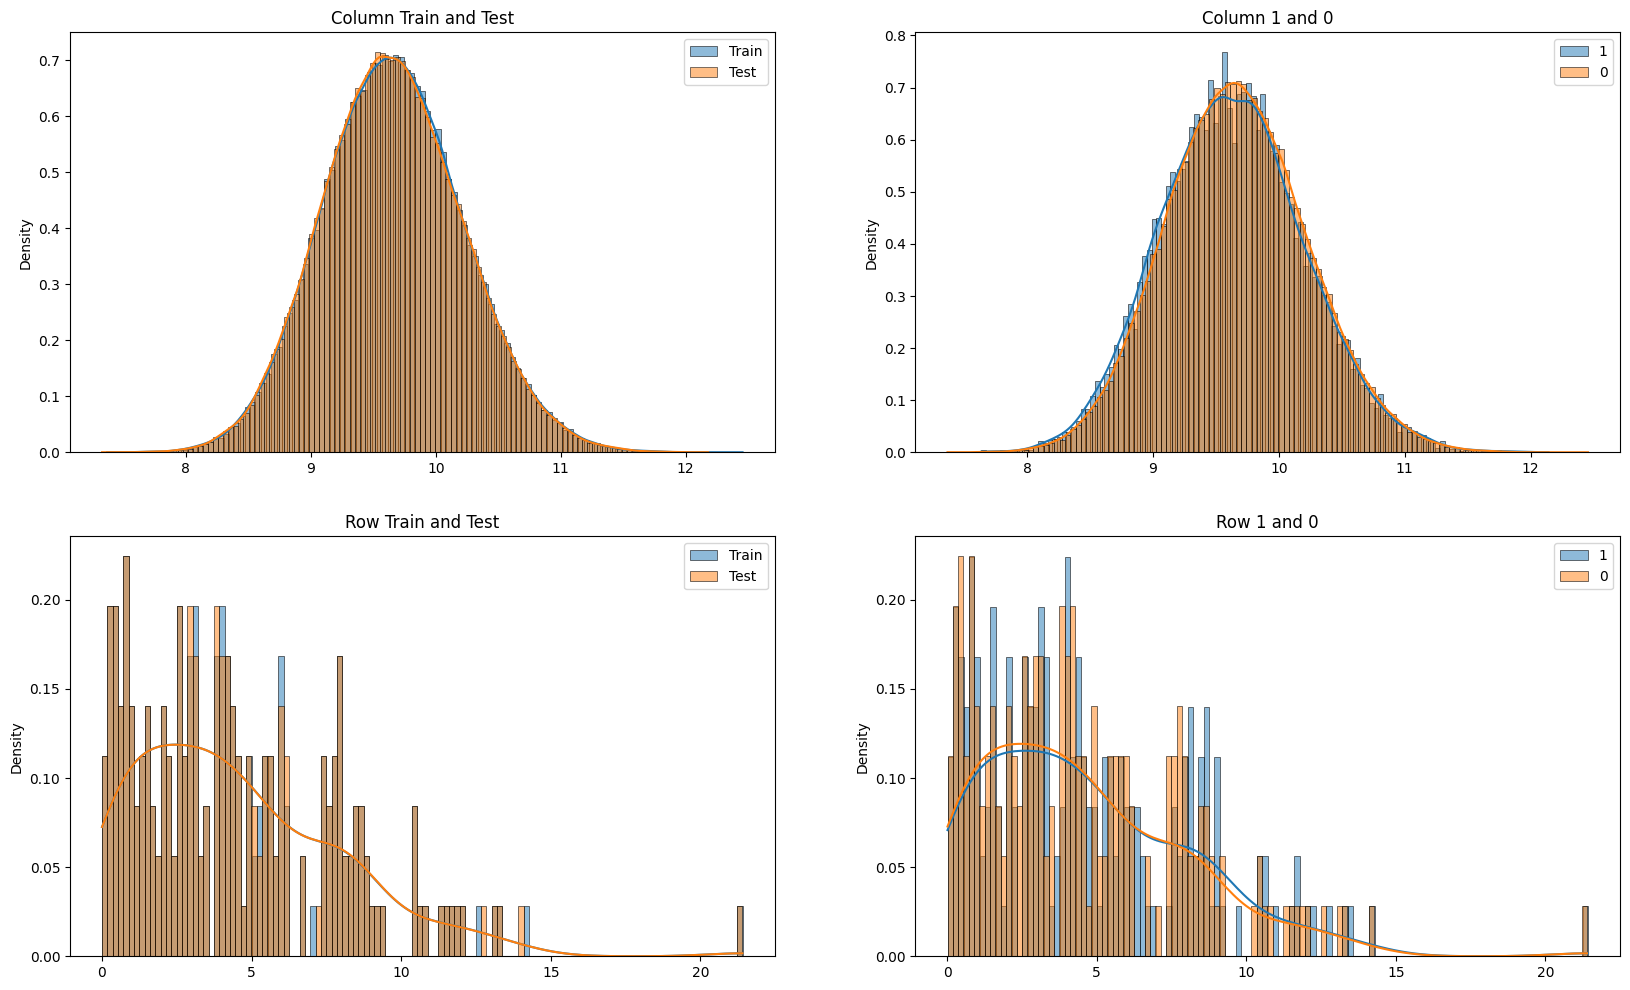

In [46]:
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[2:202]
plt.subplot(2,2,1)
plt.title('Column Train and Test')
sns.histplot(data = train_df[features].std(axis = 1), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].std(axis = 1), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,2)
plt.title('Column 1 and 0')
sns.histplot(data = t1[features].std(axis = 1), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].std(axis = 1), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,3)
plt.title('Row Train and Test')
sns.histplot(data = train_df[features].std(axis = 0), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].std(axis = 0), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,4)
plt.title('Row 1 and 0')
sns.histplot(data = t1[features].std(axis = 0), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].std(axis = 0), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.show()

### Min

<Figure size 640x480 with 0 Axes>

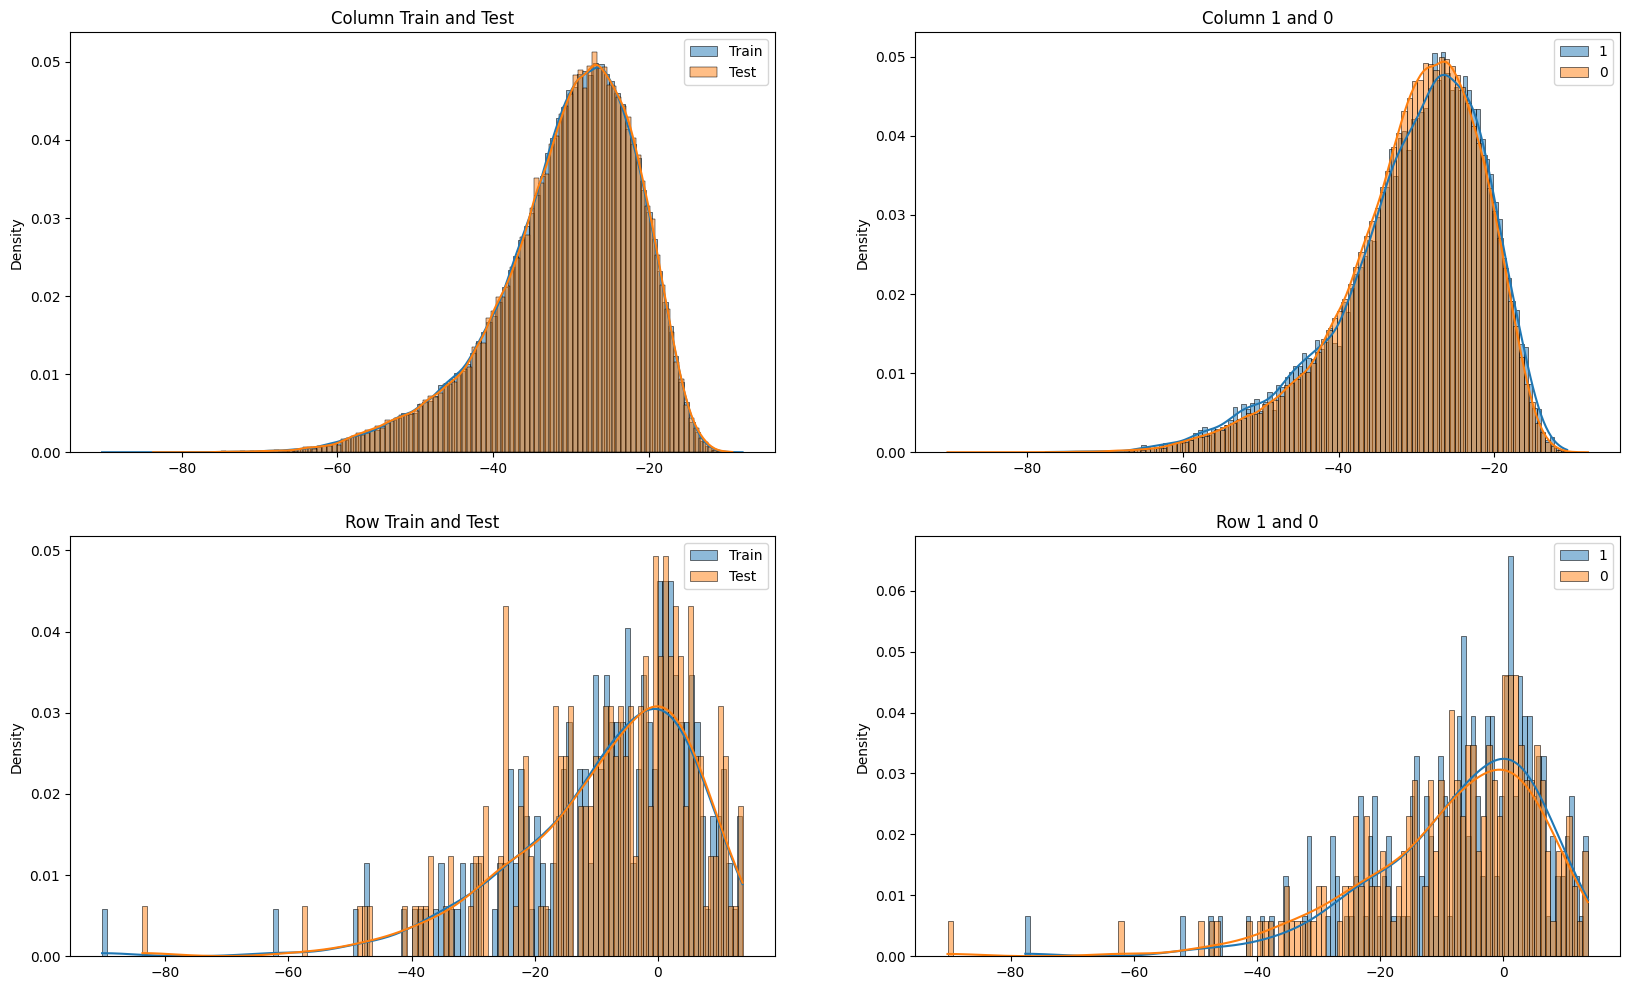

In [45]:
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[2:202]
plt.subplot(2,2,1)
plt.title('Column Train and Test')
sns.histplot(data = train_df[features].min(axis = 1), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].min(axis = 1), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,2)
plt.title('Column 1 and 0')
sns.histplot(data = t1[features].min(axis = 1), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].min(axis = 1), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,3)
plt.title('Row Train and Test')
sns.histplot(data = train_df[features].min(axis = 0), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].min(axis = 0), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,4)
plt.title('Row 1 and 0')
sns.histplot(data = t1[features].min(axis = 0), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].min(axis = 0), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.show()

### Max

<Figure size 640x480 with 0 Axes>

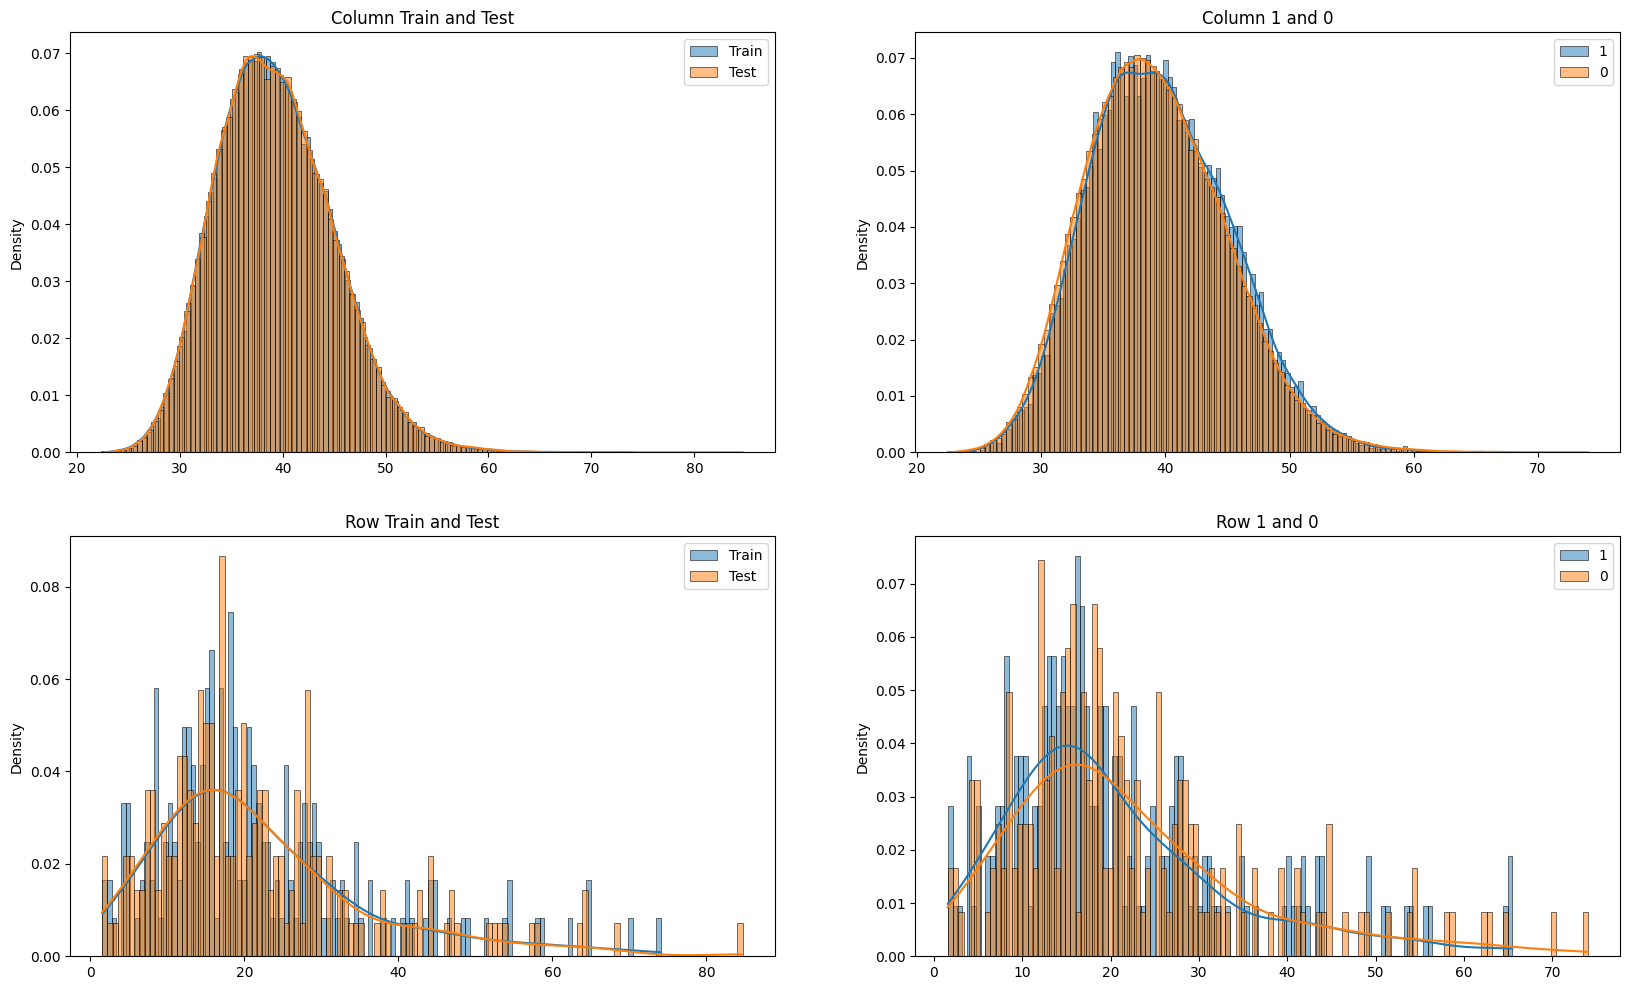

In [44]:
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[2:202]
plt.subplot(2,2,1)
plt.title('Column Train and Test')
sns.histplot(data = train_df[features].max(axis = 1), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].max(axis = 1), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,2)
plt.title('Column 1 and 0')
sns.histplot(data = t1[features].max(axis = 1), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].max(axis = 1), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,3)
plt.title('Row Train and Test')
sns.histplot(data = train_df[features].max(axis = 0), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].max(axis = 0), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,4)
plt.title('Row 1 and 0')
sns.histplot(data = t1[features].max(axis = 0), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].max(axis = 0), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.show()

### Skew

<Figure size 640x480 with 0 Axes>

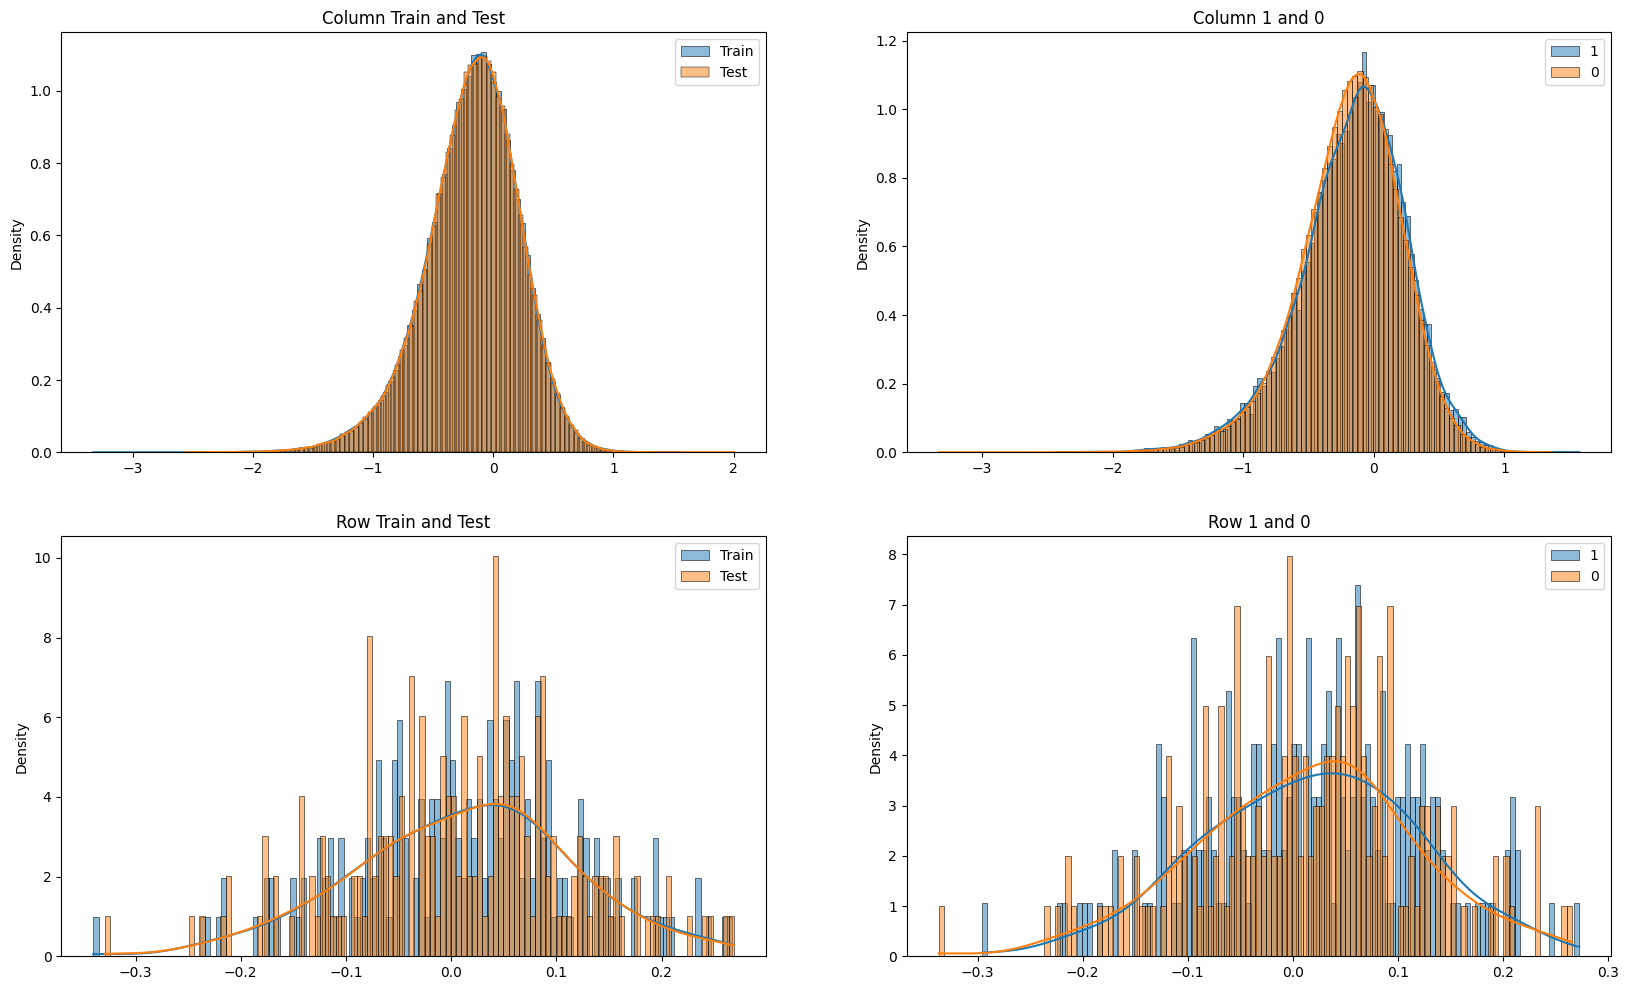

In [43]:
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[2:202]
plt.subplot(2,2,1)
plt.title('Column Train and Test')
sns.histplot(data = train_df[features].skew(axis = 1), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].skew(axis = 1), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,2)
plt.title('Column 1 and 0')
sns.histplot(data = t1[features].skew(axis = 1), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].skew(axis = 1), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,3)
plt.title('Row Train and Test')
sns.histplot(data = train_df[features].skew(axis = 0), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].skew(axis = 0), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,4)
plt.title('Row 1 and 0')
sns.histplot(data = t1[features].skew(axis = 0), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].skew(axis = 0), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.show()

### Kurtosis

<Figure size 640x480 with 0 Axes>

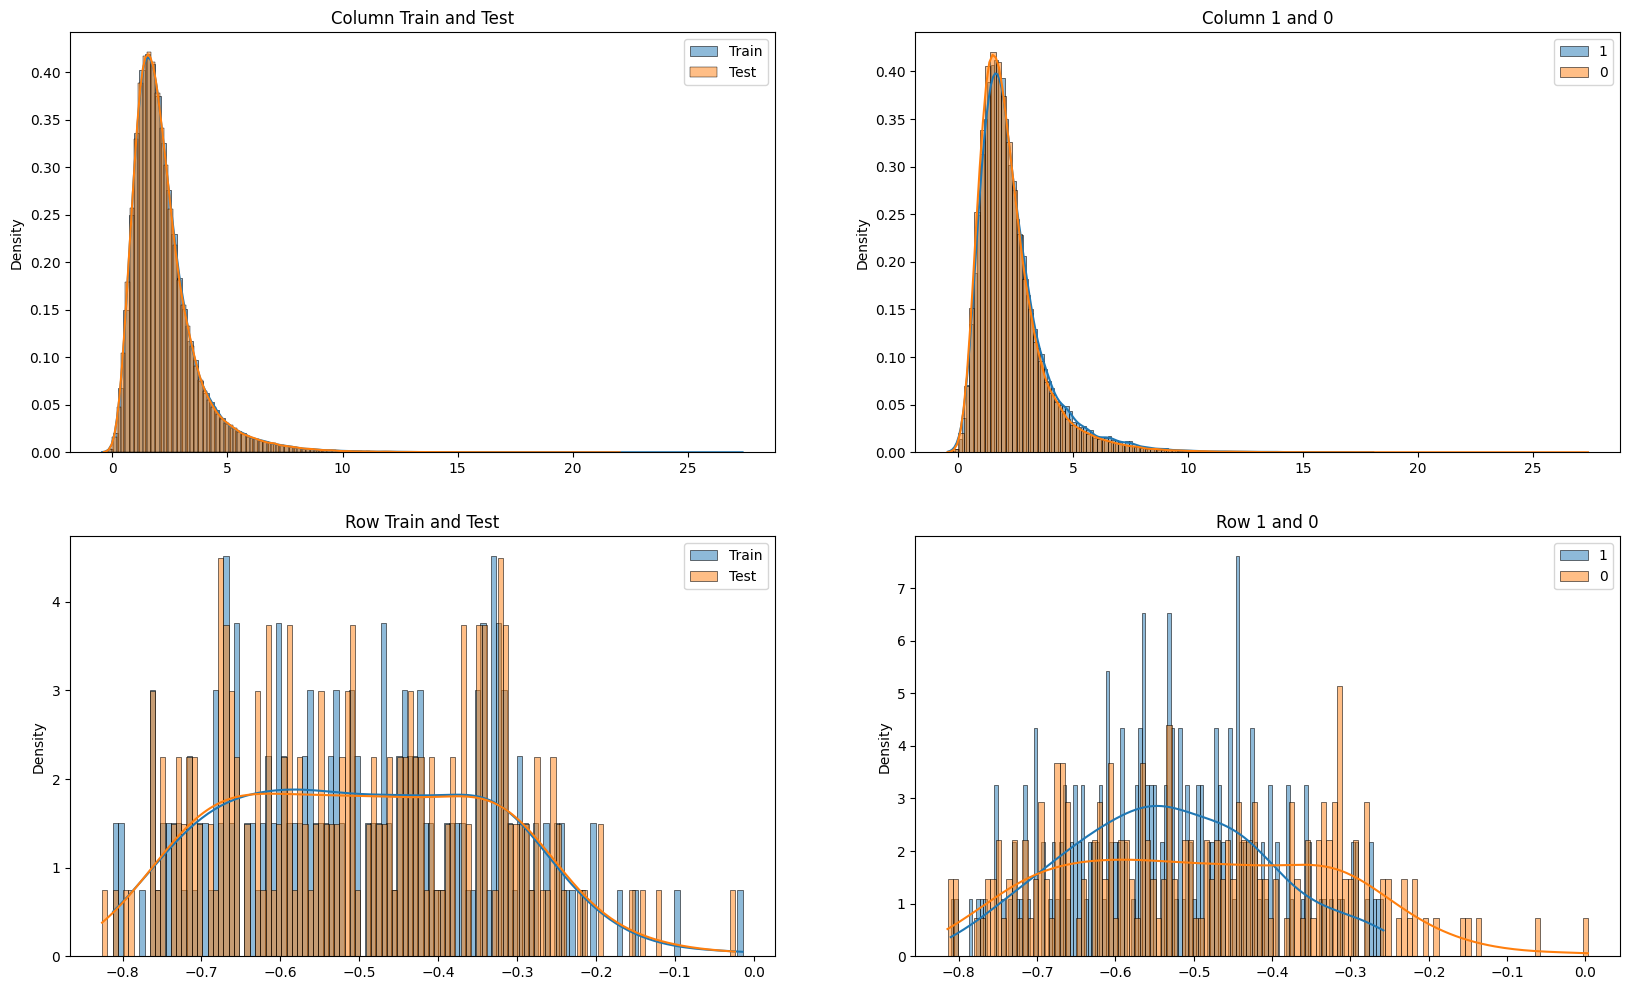

In [42]:
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[2:202]
plt.subplot(2,2,1)
plt.title('Column Train and Test')
sns.histplot(data = train_df[features].kurtosis(axis = 1), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].kurtosis(axis = 1), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,2)
plt.title('Column 1 and 0')
sns.histplot(data = t1[features].kurtosis(axis = 1), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].kurtosis(axis = 1), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,3)
plt.title('Row Train and Test')
sns.histplot(data = train_df[features].kurtosis(axis = 0), label = 'Train', kde = True,bins=120,stat="density")
sns.histplot(data = test_df[features].kurtosis(axis = 0), label = 'Test', kde = True,bins=120,stat="density")
plt.legend()
plt.subplot(2,2,4)
plt.title('Row 1 and 0')
sns.histplot(data = t1[features].kurtosis(axis = 0), label = '1', kde = True,bins=120,stat="density")
sns.histplot(data = t0[features].kurtosis(axis = 0), label = '0', kde = True,bins=120,stat="density")
plt.legend()
plt.show()

## **Check Data**

### Check Balance

<Axes: xlabel='target', ylabel='count'>

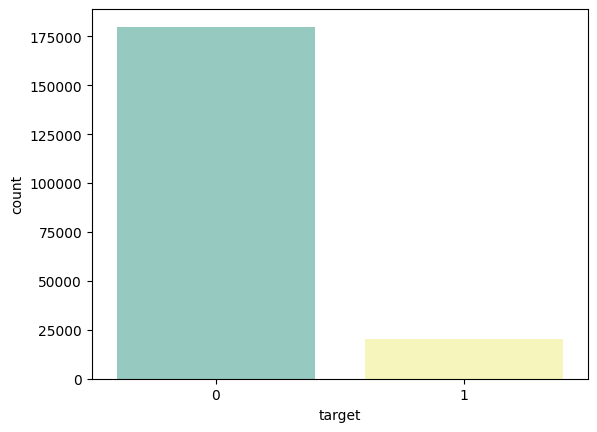

In [22]:
sns.countplot(x="target",data = train_df, palette='Set3')

### Check Duplicates

In [23]:
features = train_df.columns.values[2:202]
max_train = []
max_test = []
for i in features:
    frequency = train_df[i].value_counts()
    max_train.append([i,frequency.max(),frequency.idxmax()])
    frequency = test_df[i].value_counts()
    max_test.append([i,frequency.max(),frequency.idxmax()])
max_train = pd.DataFrame(max_train,columns=["feature","max dup","value"]).sort_values(by="max dup",ascending=False)
max_test = pd.DataFrame(max_test,columns=["feature","max dup","value"]).sort_values(by="max dup",ascending=False)


In [24]:
max_train.head(10)

feature  max dup    value
68    var_68     1084   5.0214
108  var_108      313  14.1999
126  var_126      305  11.5356
12    var_12      203  13.5545
91    var_91       66   6.9919
103  var_103       61   1.6662
148  var_148       59   4.0456
71    var_71       54   0.7031
161  var_161       52   5.7688
25    var_25       41  13.6723

In [25]:
max_test.head(10)

feature  max dup    value
68    var_68     1104   5.0197
126  var_126      307  11.5357
108  var_108      302  14.1999
12    var_12      188  13.5546
91    var_91       86   6.9939
103  var_103       78   1.4659
148  var_148       74   4.0004
161  var_161       69   5.7114
25    var_25       60  13.5965
71    var_71       60   0.5389

# **Feature Engineering**

## **Correlation**

In [26]:
corr = train_df[features].corr().abs().unstack().sort_values().reset_index()
corr = corr[corr['level_0'] != corr['level_1']]

In [27]:
corr.head()

level_0  level_1             0
0  var_191   var_75  2.703975e-08
1   var_75  var_191  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07

In [28]:
corr.tail()

level_0  level_1         0
39795   var_81  var_165  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798  var_139   var_26  0.009844
39799   var_26  var_139  0.009844

## **Make Features**

In [29]:
features = train_df.columns.values[2:202]
for df in [train_df, test_df]:
    df['sum'] = df[features].sum(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['min'] = df[features].min(axis=1)
    df['max'] = df[features].max(axis=1)
    df['std'] = df[features].std(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    df['skew'] = df[features].skew(axis=1)

In [30]:
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_197  var_198  var_199        sum      mean      min  \
0  18.6266  ...   8.5635  12.7803  -1.0914  1456.3182  7.281591 -21.4494   
1  16.5338  ...   8.7889  18.3560   1.9518  1415.3636  7.076818 -47.3797   
2  14.6155  ...   8.2675  14.7222   0.3965  1240.8966  6.204483 -22.4038   
3  14.9250  ...  10.2922  17.9697  -8.9996  1288.2319  6.441159 -35.1659   
4  19.2514  ...   9.5031  17.9974  -8.8104  1354.2310  6.771155 -65.4863   

       max        std      kurt      skew  
0  43.1127   9.331540  1.331023  0.101580  
1  40.5632  10.336130  4.110215 -0.351734  
2  33.8820   8.753387  0.546438 -0.056957  
3  38.1015   9.594064  2.630499 -0.480116  
4  41.1037  11.287122  9.787399 -1.463426  

[5 rows x 209 columns]

In [31]:
test_df.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_197  var_198  var_199        sum      mean  \
0  18.2675  2.1337  ...  10.7200  15.4722  -8.7197  1416.6404  7.083202   
1  18.6316 -4.4131  ...   9.8714  19.1293 -20.9760  1249.6860  6.248430   
2  20.2537  1.5233  ...   7.0618  19.8956 -23.1794  1430.2599  7.151299   
3  20.5660  3.3755  ...   9.2295  13.0168  -4.2108  1411.4447  7.057223   
4  10.6048  2.9890  ...   7.2882  13.9260  -9.1846  1423.7364  7.118682   

       min      max        std      kurt      skew  
0 -31.9891  42.0248   9.910632  1.871262 -0.088518  
1 -41.1924  35.6020   9.541267  3.391068 -0.559785  
2 -34.3488  39.3654   9.967466  2.326901 -0.135084  
3 -21.4797  40.3383   8.257204  2.253054 -0.167741  
4 -24.8254  45.5510  10.043542  2.044943  0.293484  

[5 rows x 208 columns]

# **Model**

In [32]:
features = train_df.columns.values[2:]
target = train_df['target']

In [33]:
label = 'target' 
metric = 'roc_auc'  

predictor = TabularPredictor(label=label, eval_metric=metric).fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=3600
)

No path specified. Models will be saved in: "AutogluonModels/ag-20260115_133225"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Memory:         GPU 0: 15.89/15.89 GB
Total GPU Memory:   Free: 15.89 GB, Allocated: 0.00 GB, Total: 15.89 GB
GPU Count:          1
Memory Avail:       28.59 GB / 31.35 GB (91.2%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True

# **Evaluation**

In [36]:
predictor.leaderboard(train_df, silent=True)

model  score_test  score_val eval_metric  pred_time_test  \
0      LightGBM_BAG_L1    0.986310   0.892195     roc_auc       97.579327   
1  WeightedEnsemble_L3    0.982080   0.895681     roc_auc      238.628122   
2  WeightedEnsemble_L2    0.982080   0.895681     roc_auc      238.629044   
3    LightGBMXT_BAG_L1    0.978761   0.894658     roc_auc      141.046000   

   pred_time_val     fit_time  pred_time_test_marginal  \
0      34.483904   648.376028                97.579327   
1      76.281513  1628.303426                 0.002795   
2      76.275635  1627.953768                 0.003718   
3      41.761809   977.946471               141.046000   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0               34.483904         648.376028            1       True   
1                0.035801           1.980927            3       True   
2                0.029922           1.631269            2       True   
3               41.761809         977.946471            1       True   

   fit_order  
0          2  
1          4  
2          3  
3          1

In [41]:
predictor.evaluate(train_df)

{'roc_auc': 0.9820803013262275,
 'accuracy': 0.952655,
 'balanced_accuracy': 0.772384866742704,
 'mcc': 0.707944209290464,
 'f1': 0.6988901962031354,
 'precision': 0.9682791435368755,
 'recall': 0.5467708229674595}

In [37]:
predictions = predictor.predict_proba(test_df)[1]

# **Submission**

In [38]:
submission = pd.DataFrame({
    'ID_code': test_df['ID_code'],
    'target': predictions
})

In [39]:
submission.head()

ID_code    target
0  test_0  0.089542
1  test_1  0.224826
2  test_2  0.218009
3  test_3  0.144364
4  test_4  0.048261

In [40]:
submission.to_csv('submission.csv', index=False)

# **Reference**

https://www.kaggle.com/code/gpreda/santander-eda-and-prediction